In [1]:
%load_ext rpy2.ipython

import sys 
import os
import math
import datetime
import os
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("."))
from analysis import *


/home/adfaure/Projects/colmet_book/experiments/interferences/analysis


In [ ]:
instances = [ 
    Instances("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_no_kali_1bcast_50subdiv/"),
    Instances("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_noperiods_1bcast_50subdiv/"),
    Instances("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_periods10s_1bcast_50subdiv/"),
    Instances("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_periods30s_1bcast_50subdiv/"),
            ]

In [12]:
for insts in instances:
    print("--")
    print(insts.name, insts.get_mean_runtime())

--
30f12a5a 310.8974719730013
60611446 310.54437575500197
2809c99a 310.59658252900044
8de5dda3 310.7183746539995
76a3ffb3 311.21786531000186
256cores_no_kali_1bcast_50subdiv 310.794934044201
--
0d026b04 912.4197392230016
f25f9adb 920.5990624379992
93669c66 736.0457421910014
447e23d1 916.7601760199997
86792239 930.6444189289996
256cores_noperiods_1bcast_50subdiv 883.2938277602003
--
3ffb947d 485.2323109210009
79ed92d2 483.52565853700065
b2a0a382 484.2684044000016
16d6906e 485.64693192200133
c7bde86d 487.6413589969997
256cores_periods10s_1bcast_50subdiv 485.2629329554008
--
29782626 474.85050381700063
95991ec1 475.71907285299864
1914d245 474.362019229
1104cbc2 475.13819389900164
4acf787e 473.32399762499705
256cores_periods30s_1bcast_50subdiv 474.67875748459954


/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/nix/store/2h7vm6ii3gwmsb98rprihzvk5wy3qcai-python3-3.7.4-env/lib/python3.7/site-packa

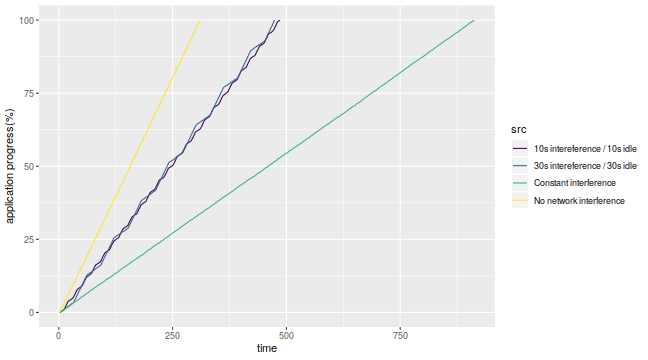

In [2]:
%%R -w 9 -h 5 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

test =  read_csv("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_no_kali_1bcast_50subdiv/2809c99a/mpi_progress.csv") %>%
                  mutate(src = "No network interference") %>% 
        bind_rows( read_csv("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_noperiods_1bcast_50subdiv/0d026b04/mpi_progress.csv") %>%
                  mutate(src = "Constant interference") ) %>% 
        bind_rows( read_csv("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_periods10s_1bcast_50subdiv/16d6906e/mpi_progress.csv") %>%
                  mutate(src = "10s intereference / 10s idle") ) %>%
        bind_rows( read_csv("../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_periods30s_1bcast_50subdiv/1914d245/mpi_progress.csv") %>%
                  mutate(src = "30s intereference / 30s idle") )
        
test = test %>% mutate(progress = loop/max(loop)*100)
test %>% ggplot(aes(x = max_comp_end, y = progress)) + ylab("application progress(%)") + xlab("time") + 
    geom_line(aes(color = src)) + 
    ggsave("/tmp/progress.png") + scale_colour_viridis_d()

# Analysis of differents kind of interferences


## periodic 30s interferences / 30s idle on grisou

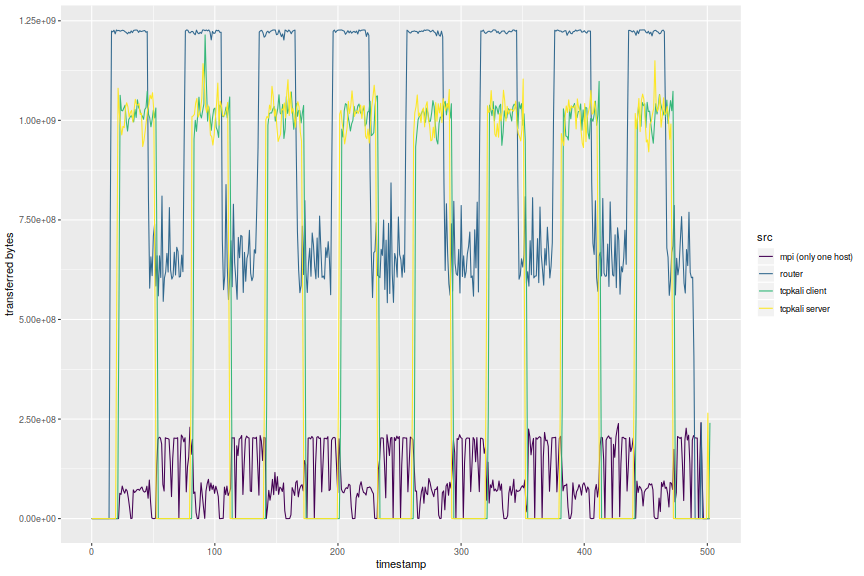

In [8]:
%%R -w 12 -h 8 --units in
library(tidyverse)
library(viridis)

instance = "../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_periods30s_1bcast_50subdiv/29782626/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-33.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali server", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "grisou-13.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (only one host)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) + 
    ylab("transferred bytes") + 
    geom_line(aes(color = src)) + 
    scale_colour_viridis_d() + ggsave("/tmp/plot.png") 

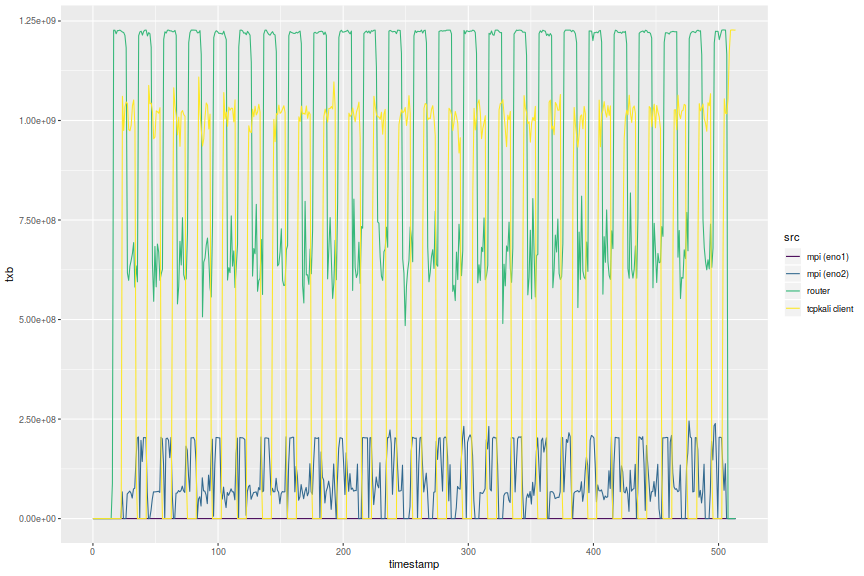

In [18]:
%%R -w 12 -h 8 --units in
library(tidyverse)

instance = "../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_periods10s_1bcast_50subdiv/16d6906e/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "mpi (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) +
    geom_line(aes(color = src)) +
    scale_colour_viridis_d() + 
    ggsave("/tmp/plot.png")

## No Interference

/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  `#timestamp` = col_double(),
  cpu_cycles = col_double(),
  instructions = col_double(),
  rxp = col_double(),
  rxb = col_double(),
  txp = col_double(),
  txb = col_double(),
  X8 = col_logical()
)

  warnings.warn(x, RRuntimeWarning)
/nix/store/l81620lq18k9vjnl14xklp9zdm6wpprm-python3-3.7.4-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 8 in image

  warnings.warn(x, RRuntimeWarning)


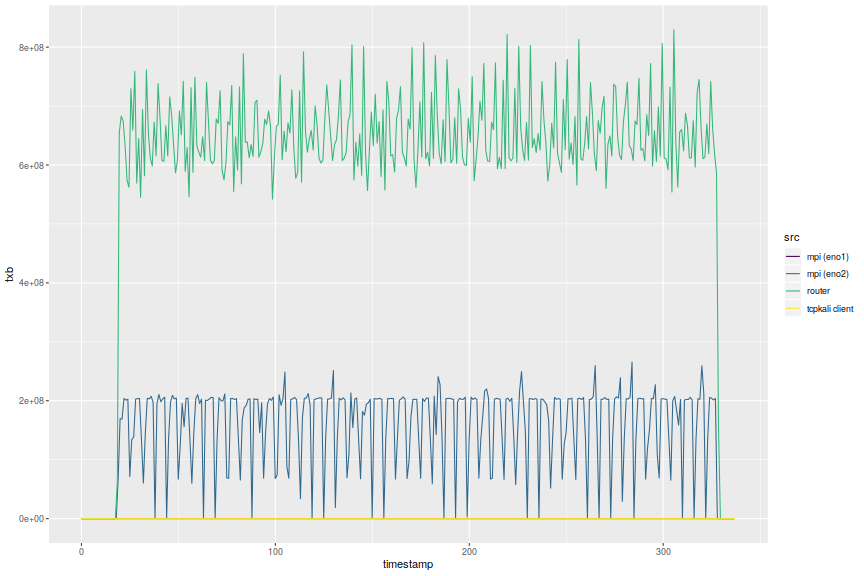

In [22]:
%%R -w 12 -h 8 --units in
library(tidyverse)

instance = "../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_no_kali_1bcast_50subdiv/2809c99a/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "mpi (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) +
    geom_line(aes(color = src)) +
    scale_colour_viridis_d() + 
    ggsave("/tmp/plot.png")

## Constant interference

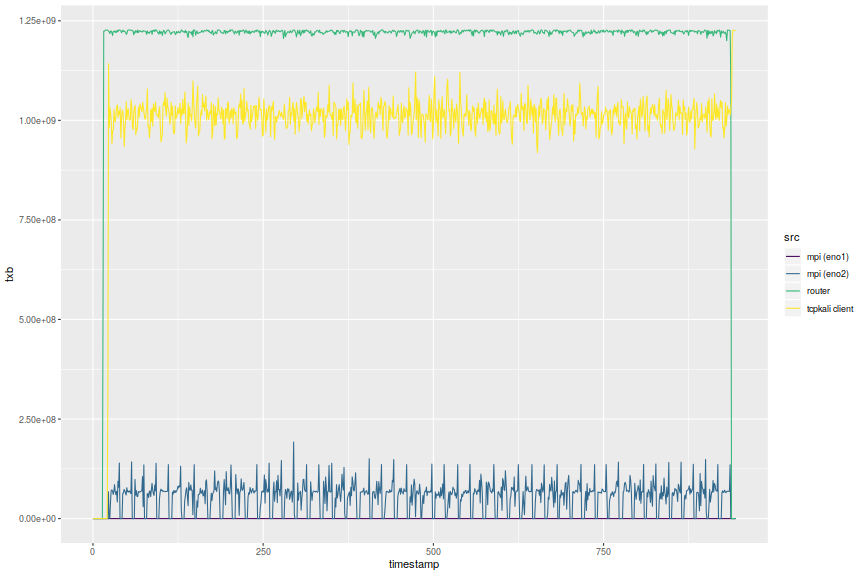

In [21]:
%%R -w 12 -h 8 --units in
library(tidyverse)

instance = "../data/grisou/80K_256ranks_1bcast_50subdiv_grisou/256cores_noperiods_1bcast_50subdiv/447e23d1/"

test = read_table2(paste0(instance, "grisou-1.nancy.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "router", timestamp = timestamp - min(timestamp)) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-10.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "tcpkali client", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "mpi (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-11.nancy.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "mpi (eno1)", timestamp = timestamp - min(timestamp)) ) 

test %>% mutate() %>% ggplot(aes(x = timestamp, y = txb)) +
    geom_line(aes(color = src)) +
    scale_colour_viridis_d() + 
    ggsave("/tmp/plot.png")